# WEB SCRAPING + APIs PROJECT

## Description

Creator: Luis Farre
Date: 20/02/2020

Description: El objetivo de este proyecto es obtener los datos necesarios 
para entender si existe una correlacion entre la cotizacion de las acciones 
de una empresa con la facturacion de esta.

Para ello se ha sacado informacion sobre los resultados de www.investing.com
Y se ha utilizado la api www.financialmodelingprep.com para obtener la evolucion de la cotizacion.


## Imports

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import base64
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
import ipywidgets as widgets
from IPython.display import display
import re
import time
from selenium import webdriver

## Web Scraping

### Unites States 50 Companies

In [2]:
'''Se inspecciona la web y medinte el id, se saca la informacion completa de la tabla'''


url='https://investing.com/equities'
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}

html=requests.get(url,headers=headers).content
soup=BeautifulSoup(html,'lxml')

table = soup.find_all('table',{'id':'cross_rate_markets_stocks_1'})[0]

In [3]:
rows=table.find_all('tr')
rows=rows[1:]

In [4]:
'''Se obtienen los nombres de todas las empresas y los 
links especificos para entrar a ver el perfil y la informacion de cada una de ellas'''

titles = [row.a.get('title') for row in rows]
links = [row.a.get('href') for row in rows]

### Widget to choose Company

In [20]:
'''Se crea un diccionario con todas las empresas de la tabla como key y el link como value'''

dict_companies = { titles[i] : links[i] for i in range(len(titles)) }

In [21]:
'''Se genera un widget Dropdown que permita seleccionar la empresa que se quiere hacer el analysis'''
companies_dropdown=widgets.Dropdown(options=titles,description='Company:')
companies_dropdown

Dropdown(description='Company:', options=('Chevron Corp', 'Citigroup Inc', 'Bank of America Corp', 'AT&T Inc',…

In [23]:
'''Se obtiene el value (link) de aquella empresa para poder acceder 
a la informacion especifica posteriormente'''

company_web=dict_companies.get(companies_dropdown.value)
company_web

'/equities/mcdonalds'

### Find Company acronym for API call

In [25]:
'''Se realiza web scraping dentro del perfil de la empresa seleccionada'''

url=f'https://investing.com{company_web}-earnings'
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36'}

#https://es.investing.com/equities/morehistory

html=requests.get(url,headers=headers).content
soup=BeautifulSoup(html,'lxml')

In [27]:
'''Se obtiene el acronimo de la empresa para poder posteriormente hacer el request a la API'''

name_api = soup.find_all('h1',{'class':'float_lang_base_1 relativeAttr'})
name_api = name_api[0].text.strip().split('\n')
name_api=re.findall('\((.*)\)',name_api[0])[0]
name_api

'MCD'

###  Webdriver Company Results

In [28]:
'''Mediante webdriver se accede a la web de la empresa donde estan 
los resultados trimestrales y se hace click en el apartado 
show more 3 veces para poder hacer luego scraping y sacar la informacion de la tabla completa.

La manera de hacerlo es mediante entrar a la web (driver), al ejecutar este codigo 
se abrira el navegador y ejecutara acciones en la web para mostrar la tabla.

Se utiliza time.sleep para dar tiempo a la web a cargar la informacion

Es necesario tener el chromedriver de la misma version que el navegador'''

driver = webdriver.Chrome('/Users/inesgalofrebofill/Documents/Ironhack/chromedriver')
driver.get(f'https://investing.com{company_web}-earnings');
time.sleep(2)
search_box = driver.find_elements_by_id('showMoreEarningsHistory')[0]
search_box.click()
time.sleep(2)
search_box.click()
time.sleep(2)
search_box.click()

time.sleep(2)
df = pd.read_html(driver.page_source)[0]

time.sleep(2)
driver.quit()
df.head(4)

,Release Date,Period End,EPS,/ Forecast,Revenue,/ Forecast.1
0,"Apr 22, 2020",03/2020,--,/ 1.9,--,/ 5.14B
1,"Jan 29, 2020",12/2019,1.97,/ 1.96,5.35B,/ 5.31B
2,"Oct 22, 2019",09/2019,2.11,/ 2.21,5.43B,/ 5.49B
3,"Jul 26, 2019",06/2019,2.05,/ 2.05,5.34B,/ 5.33B


In [29]:
'''Se elimina toda columna que no tenga importe de Revenue ya que es irrelevante para el analisis'''

df=df[df.Revenue != '--']

In [34]:
'''Se utiliza Regex para limpiar un poco las columnas e intentar traducir las unidades B y M en numericas. 
Es algo que no se ha conseguido que funcione a la perfeccion. '''


df['Release Date']=pd.to_datetime(df['Release Date']).dt.date
df['Period_End']=pd.to_datetime(df['Period End']).dt.date
df=df.replace('[,]', '', regex=True)
df['Forecast_EPS']=df['/ Forecast'].replace('/', '', regex=True)
df['Revenue2']=df['Revenue'].replace('M', '', regex=True)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('.', '') if x.endswith('B') else x)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('B', '00') if x.endswith('B') and len(x)==3 else x)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('B', '000') if x.endswith('B') and len(x)==2 else x)
df['Revenue2']=df['Revenue2'].apply(lambda x: x.replace('B', '0') if x.endswith('B') else x)

df['Revenue2']=df['Revenue2'].astype(float)
df['Forecast_Revenue']=df['/ Forecast.1'].replace('/', '', regex=True)

df['Forecast_Revenue']=df['Forecast_Revenue'].replace('[M]', '', regex=True)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('.', '') if x.endswith('B') else x)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('B', '00') if x.endswith('B') and len(x)==3 else x)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('B', '000') if x.endswith('B') and len(x)==2 else x)
df['Forecast_Revenue']=df['Forecast_Revenue'].apply(lambda x: x.replace('B', '0') if x.endswith('B') else x)

df['Forecast_Revenue']=df['Forecast_Revenue'].astype(float)

df_entrega=df[['Release Date','Period End','Revenue2','Forecast_Revenue']]
df_entrega.to_csv(f'Resultados_{name_api}.csv')
df.head(4)

,Release Date,Period End,EPS,/ Forecast,Revenue,/ Forecast.1,Period_End,Forecast_EPS,Revenue2,Forecast_Revenue
1,2020-01-29,12/2019,1.97,/ 1.96,5.35B,/ 5.31B,2019-12-01,1.96,5350.0,5310.0
2,2019-10-22,09/2019,2.11,/ 2.21,5.43B,/ 5.49B,2019-09-01,2.21,5430.0,5490.0
3,2019-07-26,06/2019,2.05,/ 2.05,5.34B,/ 5.33B,2019-06-01,2.05,5340.0,5330.0
4,2019-04-30,03/2019,1.72,/ 1.75,4.96B,/ 4.94B,2019-03-01,1.75,4960.0,4940.0


## API

### API call daily stock price

In [35]:
'''Se utiliza la api de www.financialmodelingprep.com para 
obtener la cotizacion historica de la empresa seleccionada anteriormente '''

url = f'https://financialmodelingprep.com/api/v3/historical-price-full/{name_api}'
response = requests.get(url)


In [37]:
result=response.json()
result
data=pd.DataFrame(json_normalize(result))
data=json_normalize(data['historical'][0])
data.head(2)

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2015-02-20,94.16,94.49,93.56,94.19,82.53,8155000.0,8155000.0,-0.03,-0.032,94.08000,"February 20, 15",-0.00032
1,2015-02-23,94.12,94.41,93.95,94.31,82.63,5682000.0,5682000.0,-0.19,-0.202,94.22333,"February 23, 15",-0.00202


In [38]:
'''Se seleccionan las columnas que realmente tienen utilidas para el analisis'''

data=data[['date','open','close','volume','change','changePercent','vwap']]
data['date']=pd.to_datetime(data['date']).dt.date

In [40]:
data.to_csv(f'Cotizacion_stocks_{name_api}.csv')

data.head(5)

,date,open,close,volume,change,changePercent,vwap
0,2015-02-20,94.16,94.19,8155000.0,-0.03,-0.032,94.08000
1,2015-02-23,94.12,94.31,5682000.0,-0.19,-0.202,94.22333
2,2015-02-24,94.08,94.98,5643600.0,-0.90,-0.957,94.66667
3,2015-02-25,94.91,98.66,16751600.0,-3.75,-3.951,97.61000
4,2015-02-26,97.43,99.51,16098800.0,-2.08,-2.135,98.79667


## Analysis and Charts

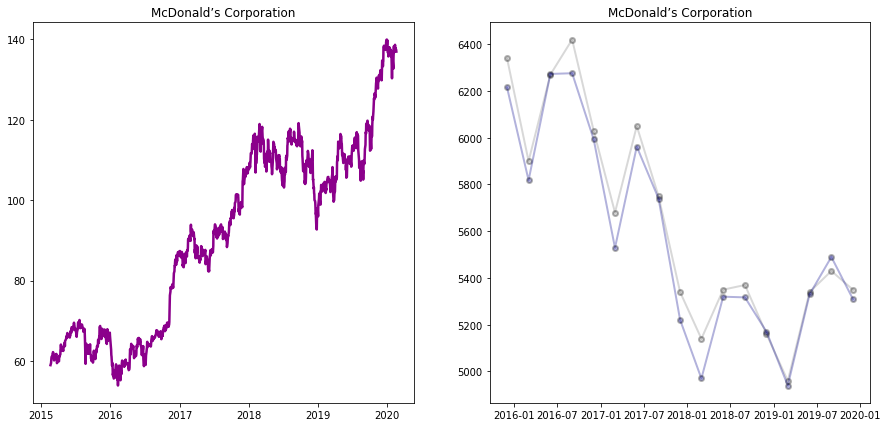

In [42]:
'''Finalmente se generan dos graficos mediante matplotlib.pyplot 
para poder visualizar mejor los datos y ver las tendencias'''

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7),subplot_kw = {'title' :companies_dropdown.value})


ax1.plot(data3.date,data3.open,
       linewidth=2.5,color='darkmagenta',label=2014)


ax2.plot(df.Period_End,df.Revenue2,
        linewidth=2,
       color='grey',
       alpha=0.3,
        marker = 'o', 
        markersize = 5,
        markeredgecolor = 'black',
        markeredgewidth = 2)

ax2.plot(df.Period_End,df.Forecast_Revenue,
        linewidth=2,
       color='darkblue',
       alpha=0.3,
        marker = 'o', 
        markersize = 5,
        markeredgecolor = 'black',
        markeredgewidth = 2)


